<a href="https://colab.research.google.com/github/tjdahlke/fishcam/blob/main/Fishcam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

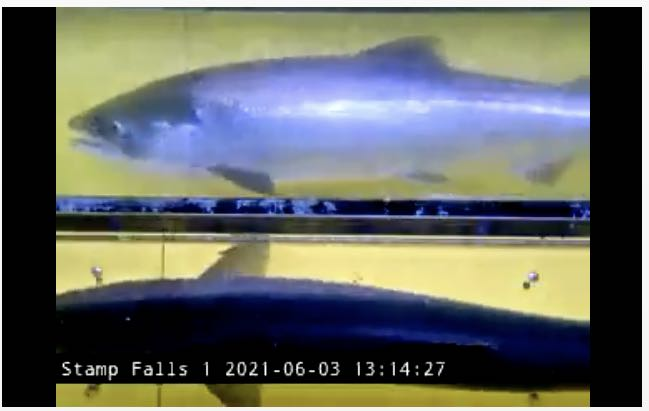

Taken from a live stream [fish cam](http://www.pacfish.ca/wcviweather/Content%20Pages/Stamp/CameraStream.aspx)

#**Fishcam**

The idea is to be able to capture a live-stream of a fish-ladder camera and do analysis on the video to count and identify fish that pass up or down stream. Currently, fish counting is still mostly done by humans reviewing video. This is time consuming, costly, and can be less accurate. 

By automatically counting fish, we can improve the quality of data that is collected for fisheries management, allowing for more real-time decision making. By making the method for collecting data cheaper, we can change the economics of scaling camera collection methods, potentially allowing for better data coverage and thus better understanding of larger fishery systems.

#Non-Youtube Live Stream
Here we connect to a video stream, and start capturing frames when we detect "significant" motion between them.

###Install dependencies

In [ ]:
!pip install selenium
!apt-get update # to update ubuntu to correctly run apt install
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin
import sys
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver') # Need to add the driver to PATH to avoid issues

###Connect to live stream

In [ ]:
mainURL="http://www.pacfish.ca/wcviweather/Content%20Pages/Stamp/CameraStream.aspx"
from selenium import webdriver
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')

from selenium.webdriver.common.desired_capabilities import DesiredCapabilities
caps = DesiredCapabilities.CHROME
caps['goog:loggingPrefs'] = {'performance': 'ALL'}
chrome_options.add_argument("--window-size=1920,1080")
driver = webdriver.Chrome(desired_capabilities=caps,options=chrome_options)
driver.get(mainURL)
driver.find_element_by_class_name("player-poster.clickable").click(); # You will need to customize this section according to the website you are scraping the video stream off of.


####Required customization
The section of code that uses:

`driver.find_element_by_class_name("player-poster.clickable").click();`

is specifically written for this website. I found this class name by inspecting the webpage via right-clicking on the live-stream element, then selecting "Inspect" from Chrome. I did this because when one initially loads this webpage, the live stream does not begin until it is left-clicked. You may need to use another `find` method depending on the website you are getting your live stream from. See [the docs](https://selenium-python.readthedocs.io/locating-elements.html) for more information.

###Process live stream data

In some cases I find that the stream needs to "catch-up" with the current time first, and may spit out a lot of `Received unexpected status code 404` errors for ~10-20 seconds before it begins to successfully capture frames.


In [ ]:
import json
import requests
import cv2
import datetime
import os
from google.colab.patches import cv2_imshow
import imutils


def process_browser_log_entry(entry):
    response = json.loads(entry['message'])['message']
    return response


capture_count=0
fishvid_count=0
min_area=20000.0
max_captures=5000 #1000 chunks seems to be abotu 40 seconds for this live stream FYI
firstFrame=None
tmpfilename="temp.mpeg"

while (capture_count < max_captures):
  browser_log = driver.get_log('performance') 
  events = [process_browser_log_entry(entry) for entry in browser_log]
  events = [event for event in events if 'Network.response' in event['method']]

  for e in events:
    if "response" in e['params']:
      url=e['params']['response']['url']
      if url.endswith('.ts'):
        r1 = requests.get(url, stream=True)
        if (r1.status_code == 200):
            print("capturing frames ...")
            capture_count=capture_count+1

            # Write the chunks to a temp file
            with open(tmpfilename,'wb') as f:
                for chunk in r1.iter_content(chunk_size=1024):
                    f.write(chunk)

            # Immediately read the temp file (not sure how to handle "chunked" streaming directly)
            capture = cv2.VideoCapture(tmpfilename)
            while capture.isOpened():
              motion=False
              grabbed, frame = capture.read()  #read in single frame
              if grabbed == False:
                break


              # Resize the frame, convert it to grayscale, and blur it
              # frame = imutils.resize(frame, width=100)
              gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
              gray = cv2.GaussianBlur(gray, (21, 21), 0)
              # if the first frame is None, initialize it
              if firstFrame is None:
                firstFrame = gray
                continue


              # compute the absolute difference between the current frame and
              # first frame
              frameDelta = cv2.absdiff(firstFrame, gray)
              thresh = cv2.threshold(frameDelta, 25, 255, cv2.THRESH_BINARY)[1]
              # dilate the thresholded image to fill in holes, then find contours
              # on thresholded image
              thresh = cv2.dilate(thresh, None, iterations=2)
              cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
                cv2.CHAIN_APPROX_SIMPLE)
              cnts = imutils.grab_contours(cnts)
              # loop over the contours
              for c in cnts:
                # if the contour is too small, ignore it
                if (cv2.contourArea(c) < min_area):
                  continue
                # compute the bounding box for the contour, draw it on the frame,
                (x, y, w, h) = cv2.boundingRect(c)
                cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
                motion=True


              if (motion):
                # Rename the video for saving
                print("OMGOSH WE SAW A FISH!!!!")
                newfilename="fishvid_" + str(fishvid_count) + ".mpeg"
                print("Writing video to file:  ",newfilename)
                os.rename(tmpfilename, newfilename)
                fishvid_count=fishvid_count+1
                cv2_imshow(frame)
                break
                # show the frame and record if the user presses a key
                # cv2_imshow(thresh)
                # cv2_imshow(frameDelta)


            # cleanup the camera and close any open windows
            capture.release()
            cv2.destroyAllWindows()  #close the windows automatically


        else:
            print("Received unexpected status code {}".format(r1.status_code))

### Download files to local system

In [ ]:
from google.colab import files

for i in range(0,44):
  file="fishvid_"+str(i)+".mpeg"
  print(file)
  files.download(file)

#Youtube Live Stream
This section is still under development. Frankly, we haven't found any interesting fishcam streams on Youtube yet, so this has not been a priority.

###Install dependencies

In [ ]:
!pip install pafy youtube_dl

     |████████████████████████████████| 1.9MB 11.0MB/s 


### Capture and process live stream

In [ ]:
import pafy
import youtube_dl
import cv2
from google.colab.patches import cv2_imshow

url = "https://www.youtube.com/watch?v=HeFnqUALymQ"
video = pafy.new(url)
best = video.getbest(preftype="mp4")
capture = cv2.VideoCapture(best.url)

while capture.isOpened():
  grabbed, frame = capture.read()  #read in single frame
  if grabbed == False:
    break

  #openCV processing goes here
  #

  cv2_imshow(frame)  #Show the frame

  #Shown in a new window, To exit, push q on the keyboard
  if cv2.waitKey(20) & 0xFF == ord('q'):
    break

capture.release()
cv2.destroyAllWindows()  #close the windows automatically